In [1]:
"""
Two-Stage-To-Orbit Design Problem with Environmental Optimization
Modified to minimize Life Cycle Assessment (LCA) score instead of GLOW

L. BREVAULT (ONERA/DTIS), M. BALESDENT (ONERA/DTIS)
Modified for environmental optimization
"""

import numpy as np
import pandas as pd
import sys
np.set_printoptions(threshold=sys.maxsize)
from matplotlib import pyplot as plt
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Import OpenMDAO + CMA-ES optimization algorithm
import openmdao.api as om
import cma

# Import specific Python functions for launch vehicle design
import Launch_vehicle_Group
import post_traitement
import result_vizualization

✓ Brightway2 and ecoinvent successfully loaded


In [2]:
def setup_baseline_problem():
    """Create problem with baseline configuration"""
    P = om.Problem()
    P.model = Launch_vehicle_Group.Launcher_vehicle()
    P.setup(check=False)
    
    # Fixed trajectory parameters from CMA-ES optimization
    lowerbnd = np.array([150., 20., 0., -10., -1., 5., 5., 1., 10., 10.])
    upperbnd = np.array([600., 200., 50., 20., 1., 20., 20., 10., 70., 70.])
    x_optimal = np.array([0.23527546, 0.36153667, 0.39784285, 0.53903249, 
                         0.22424615, 0.96230176, 0.75167229, 0.8693451, 
                         0.44461484, 0.17382506])
    XX = lowerbnd + (upperbnd - lowerbnd) * x_optimal
    
    # Set fixed parameters
    P['Diameter_stage_1'] = 5.0
    P['Diameter_stage_2'] = 5.0
    P['Mass_flow_rate_stage_1'] = 300.
    P['Mass_flow_rate_stage_2'] = 200.
    P['Thrust_stage_1'] = 1000.
    P['Thrust_stage_2'] = 1000.
    P['OF_stage_1'] = 5.0
    P['OF_stage_2'] = 5.5
    P['Pc_stage_1'] = 80.
    P['Pc_stage_2'] = 60.
    P['Pe_stage_1'] = 1.0
    P['Pe_stage_2'] = 1.0
    P['N_eng_stage_1'] = 6.
    P['N_eng_stage_2'] = 1.
    
    # Fixed trajectory
    P['Prop_mass_stage_1'] = XX[0] * 1e3
    P['Prop_mass_stage_2'] = XX[1] * 1e3
    P['thetacmd_i'] = XX[2]
    P['thetacmd_f'] = XX[3]
    P['ksi'] = XX[4]
    P['Pitch_over_duration'] = XX[5]
    P['Delta_vertical_phase'] = XX[6]
    P['Delta_theta_pitch_over'] = XX[7]
    P['command_stage_1_exo'] = XX[8:10]
    P['Exit_nozzle_area_stage_1'] = 0.79
    P['Exit_nozzle_area_stage_2'] = 3.6305
    P['is_fallout'] = 0.
    
    return P

In [3]:
def evaluate_configuration(P, k_SM_values, verbose=False):
    """
    Evaluate launcher with given material composition
    k_SM_values: [thrust_frame, interstage, intertank, stage_2]
    """
    # Set material parameters
    P['k_SM_thrust_frame'] = k_SM_values[0]
    P['k_SM_interstage'] = k_SM_values[1]
    P['k_SM_intertank'] = k_SM_values[2]
    P['k_SM_stage_2'] = k_SM_values[3]
    
    # Fixed point iteration for Pdyn
    error = 100.
    P['Pdyn_max_dim'] = 40.
    k = 0
    
    while error > 1. and k < 20:
        P.run_model()
        qmax = np.max(P.get_val('pdyn_ascent'))
        error = abs(P.get_val('Pdyn_max_dim') - qmax/1e3)
        P.set_val('Pdyn_max_dim', qmax/1e3)
        k += 1
    
    # Get results
    lca_score = P['Environmental.LCA_score'][0]
    lca_manufacturing = P['Environmental.LCA_manufacturing'][0]
    lca_benefit = P['Environmental.LCA_operational_benefit'][0]
    co2_eq = P['Environmental.CO2_eq'][0]
    glow = P['GLOW'][0]
    dry_mass_1 = P['Dry_mass_stage_1'][0]
    dry_mass_2 = P['Dry_mass_stage_2'][0]
    
    # Get material masses
    al_7075_mass = P['Environmental.total_aluminum_7075_kg'][0]
    al_li_mass = P['Environmental.total_aluminum_lithium_kg'][0]
    comp_mass = P['Environmental.total_composite_kg'][0]
    steel_mass = P['Environmental.total_steel_kg'][0]
    mass_savings = P['Environmental.mass_savings_kg'][0]
    
    # Get trajectory performance
    nb_pts = int(P['Nb_pt_ascent'][0])
    alt_final = P['alt_ascent'][nb_pts-1] / 1000.0
    v_final = P['V_ascent'][nb_pts-1] / 1000.0
    
    if verbose:
        print(f"\n--- Configuration Evaluation ---")
        print(f"k_SM values: {k_SM_values}")
        print(f"LCA Score: {lca_score:.2f} Pt")
        print(f"  Manufacturing: {lca_manufacturing:.2f} Pt")
        print(f"  Operational benefit: -{lca_benefit:.2f} Pt")
        print(f"CO2 emissions: {co2_eq/1000:.1f} tonnes")
        print(f"Material masses:")
        print(f"  Aluminum 7075: {al_7075_mass:.1f} kg")
        print(f"  Aluminum Lithium: {al_li_mass:.1f} kg")
        print(f"  Composite: {comp_mass:.1f} kg")
        print(f"  Steel: {steel_mass:.1f} kg")
        print(f"  Mass savings: {mass_savings:.1f} kg")
        print(f"GLOW: {glow/1000:.2f} tonnes")
        print(f"Performance: {alt_final:.1f} km, {v_final:.2f} km/s")
    
    return {
        'lca_score': lca_score,
        'lca_manufacturing': lca_manufacturing,
        'lca_benefit': lca_benefit,
        'co2_eq': co2_eq,
        'glow': glow,
        'dry_mass_1': dry_mass_1,
        'dry_mass_2': dry_mass_2,
        'al_7075_mass': al_7075_mass,
        'al_li_mass': al_li_mass,
        'comp_mass': comp_mass,
        'alt_final': alt_final,
        'v_final': v_final,
        'mass_savings': mass_savings
    }


TESTING MATERIAL CONFIGURATIONS

Evaluating: 100% Aluminum

--- Configuration Evaluation ---
k_SM values: [1.0, 1.0, 1.0, 1.0]
LCA Score: 250.09 Pt
  Manufacturing: 250.09 Pt
  Operational benefit: -0.00 Pt
CO2 emissions: 844.0 tonnes
Material masses:
  Aluminum 7075: 9609.8 kg
  Aluminum Lithium: 12791.7 kg
  Composite: 0.0 kg
  Steel: 3144.6 kg
  Mass savings: 0.0 kg
GLOW: 381.49 tonnes
Performance: 312.2 km, 7.81 km/s

Evaluating: 100% Composite

--- Configuration Evaluation ---
k_SM values: [0.62, 0.7, 0.8, 0.75]
LCA Score: 283.29 Pt
  Manufacturing: 285.19 Pt
  Operational benefit: -1.89 Pt
CO2 emissions: 1292.0 tonnes
Material masses:
  Aluminum 7075: 545.4 kg
  Aluminum Lithium: 12570.3 kg
  Composite: 6867.6 kg
  Steel: 3033.9 kg
  Mass savings: 2639.5 kg
GLOW: 378.85 tonnes
Performance: 335.2 km, 7.77 km/s

Evaluating: 50/50 Mix

--- Configuration Evaluation ---
k_SM values: [0.81, 0.85, 0.9, 0.875]
LCA Score: 270.05 Pt
  Manufacturing: 271.00 Pt
  Operational benefit: -0.95 

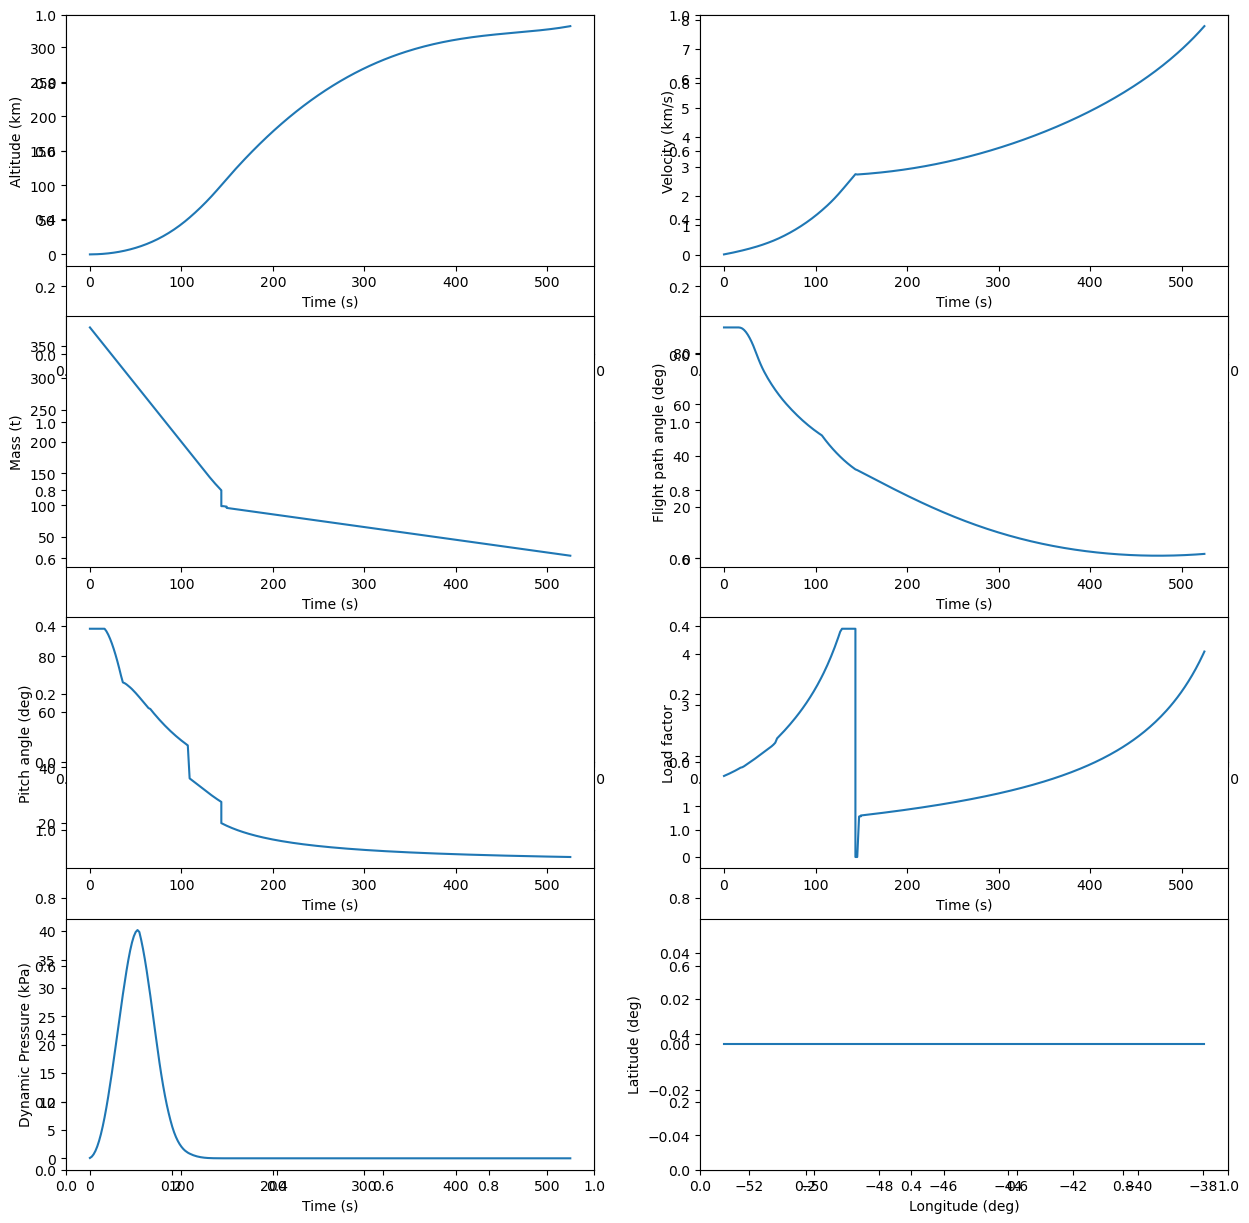

In [4]:
print("\n" + "="*80)
print("TESTING MATERIAL CONFIGURATIONS")
print("="*80)

# Create baseline problem
P_base = setup_baseline_problem()

# Test configurations
test_configs = {
    '100% Aluminum': [1.00, 1.00, 1.00, 1.00],
    '100% Composite': [0.62, 0.70, 0.80, 0.75],
    '50/50 Mix': [0.81, 0.85, 0.90, 0.875],
    'Optimized Mix': [0.70, 0.75, 0.85, 0.80],  # Educated guess
}

results = {}
for name, k_SM in test_configs.items():
    print(f"\nEvaluating: {name}")
    results[name] = evaluate_configuration(P_base, k_SM, verbose=True)

# Compare results
print("\n" + "="*80)
print("COMPARISON OF CONFIGURATIONS")
print("="*80)

df_compare = pd.DataFrame(results).T
print("\nLCA Scores:")
print(df_compare[['lca_score', 'lca_manufacturing', 'lca_benefit', 'mass_savings']].round(2))

result_vizualization.plots_output(P_base)

In [5]:
print("\n" + "="*80)
print("RUNNING CMA-ES OPTIMIZATION")
print("="*80)

def objective_function(x):
    """
    Objective function for CMA-ES - balanced LCA and performance
    x: normalized [0,1] array for k_SM values
    """
    
    from environment.Environmental_Discipline import Environmental_Discipline_Comp
    Environmental_Discipline_Comp._baseline_dry_mass = None

    # Convert normalized to actual k_SM
    k_SM_lower = np.array([0.62, 0.70, 0.80, 0.75])
    k_SM_upper = np.array([1.00, 1.00, 1.00, 1.00])
    k_SM = k_SM_lower + (k_SM_upper - k_SM_lower) * x
    
    # Create fresh problem (avoids state issues)
    P = setup_baseline_problem()
    
    # Evaluate
    result = evaluate_configuration(P, k_SM, verbose=False)
    
    # Check hard constraints (must be satisfied)
    penalty = 0
    if result['alt_final'] < 300:  # Must reach 300 km
        penalty += (300 - result['alt_final']) * 10
    if result['v_final'] < 7.5:  # Must reach 7.5 km/s
        penalty += (7.5 - result['v_final']) * 100
    if result['glow'] > 400000:  # GLOW limit 400 tonnes
        penalty += (result['glow'] - 400000) / 1000
    
    # WEIGHTED OBJECTIVES
    # Define weights (these sum to 1.0)
    w_env = 0.6   # 60% weight on environmental impact
    w_perf = 0.4  # 40% weight on performance (lower GLOW)
    
    # Normalize objectives to [0,1] range based on expected bounds
    # LCA typically ranges from 250 (pure Al) to 285 (pure composite)
    lca_min, lca_max = 250, 285
    lca_normalized = (result['lca_score'] - lca_min) / (lca_max - lca_min)
    lca_normalized = np.clip(lca_normalized, 0, 1)  # Keep in [0,1]
    
    # GLOW typically ranges from 378 to 382 tonnes
    glow_min, glow_max = 378000, 382000
    glow_normalized = (result['glow'] - glow_min) / (glow_max - glow_min)
    glow_normalized = np.clip(glow_normalized, 0, 1)  # Keep in [0,1]
    
    # Combined objective (both normalized to minimize)
    weighted_objective = w_env * lca_normalized + w_perf * glow_normalized
    
    # Scale back to typical objective range (optional, helps CMA-ES convergence)
    scaled_objective = 250 + weighted_objective * 35  # Maps [0,1] to [250,285]
    
    return scaled_objective + penalty

# Update your initial guess to start with a balanced mix
x0 = np.array([0.5, 0.5, 0.5, 0.5])  # Start with 50/50 compromise

# Optional: Add a print statement to track the trade-off
print(f"\nOptimizing with weights: {0.6*100:.0f}% environmental, {0.4*100:.0f}% performance")

# CMA-ES settings
options = {
    'seed': 42,
    'maxiter': 150,
    'popsize': 8,
    'bounds': [[0]*4, [1]*4],
    'tolfun': 1e-3,
    'verb_disp': 1
}

# Initial guess (start with mixed materials)
x0 = np.array([0.3, 0.3, 0.5, 0.3])  # Favor some composite

print("\nOptimizing material composition...")
print("Variables: [k_SM_thrust_frame, k_SM_interstage, k_SM_intertank, k_SM_stage_2]")
print("Bounds:")
print("  Thrust frame: [0.62, 1.00] (0.62=composite, 1.00=aluminum)")
print("  Interstage:   [0.70, 1.00] (0.70=composite, 1.00=aluminum)")
print("  Intertank:    [0.80, 1.00] (0.80=composite, 1.00=aluminum)")
print("  Stage 2:      [0.75, 1.00] (0.75=composite, 1.00=aluminum)")
print("-"*80)

# Run optimization
res = cma.fmin(objective_function, x0, 0.2, options)


RUNNING CMA-ES OPTIMIZATION

Optimizing with weights: 60% environmental, 40% performance

Optimizing material composition...
Variables: [k_SM_thrust_frame, k_SM_interstage, k_SM_intertank, k_SM_stage_2]
Bounds:
  Thrust frame: [0.62, 1.00] (0.62=composite, 1.00=aluminum)
  Interstage:   [0.70, 1.00] (0.70=composite, 1.00=aluminum)
  Intertank:    [0.80, 1.00] (0.80=composite, 1.00=aluminum)
  Stage 2:      [0.75, 1.00] (0.75=composite, 1.00=aluminum)
--------------------------------------------------------------------------------
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=42, Sun Sep 28 23:51:53 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.692386256933377e+02 1.0e+00 2.07e-01  2e-01  2e-01 1:33.7
    2     16 2.676964524340240e+02 1.2e+00 2.36e-01  2e-01  3e-01 2:39.8
    3     24 2.665674336892381e+02 1.5e+00 2.77e-01  3e-01  4e-01 3:55.5
    4     32 2.647991249694260e+02 1.7e+00 3.10e-01  3e-01  4e-01 5:11.3
    5     40 


OPTIMIZATION RESULTS

Optimal k_SM values:
  Thrust frame: 1.000
  Interstage:   0.922
  Intertank:    1.000
  Stage 2:      1.000

Material composition (% Aluminum):
  Thrust frame: 100.0%
  Interstage:   73.9%
  Intertank:    100.0%
  Stage 2:      100.0%

--- Configuration Evaluation ---
k_SM values: [0.99997566 0.92177958 0.99998573 0.99999976]
LCA Score: 250.13 Pt
  Manufacturing: 250.13 Pt
  Operational benefit: -0.00 Pt
CO2 emissions: 844.5 tonnes
Material masses:
  Aluminum 7075: 9599.8 kg
  Aluminum Lithium: 12791.7 kg
  Composite: 7.5 kg
  Steel: 3144.6 kg
  Mass savings: 0.0 kg
GLOW: 381.49 tonnes
Performance: 312.2 km, 7.81 km/s

IMPROVEMENT SUMMARY
Baseline LCA score: 270.05 Pt
Optimal LCA score:  250.13 Pt
Improvement:        7.4%
CO2 reduction:      262.5 tonnes

--------------------------------------------------------------------------------
Generating trajectory plots...


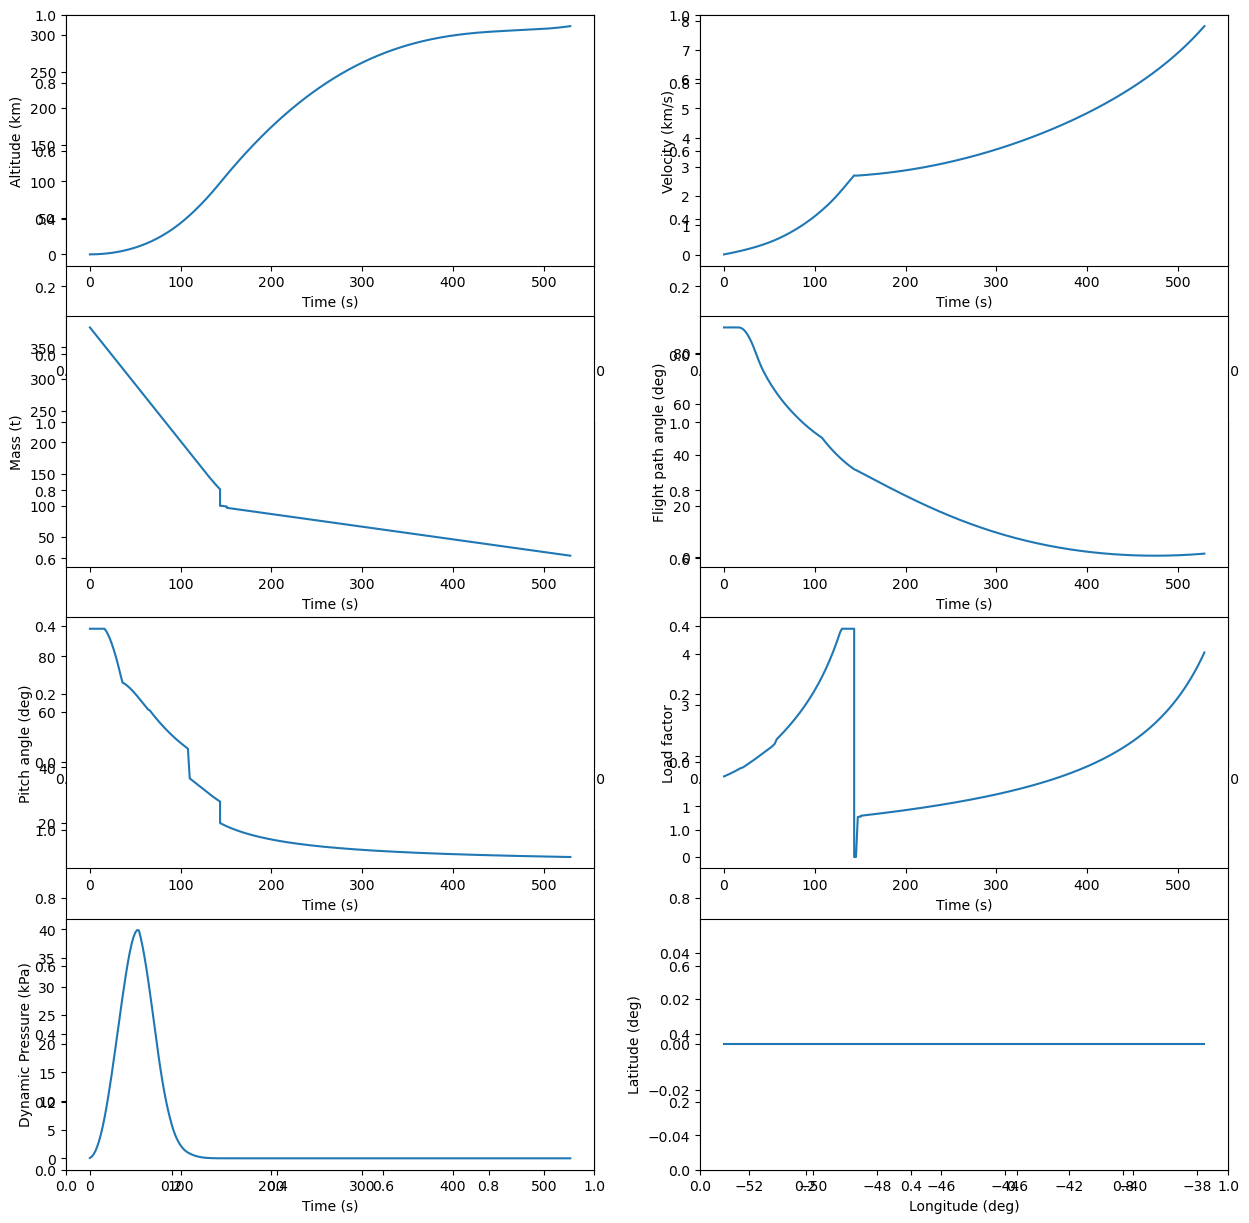


OPTIMIZATION COMPLETE


In [6]:
print("\n" + "="*80)
print("OPTIMIZATION RESULTS")
print("="*80)

# Get optimal k_SM values
x_opt = res[0]
k_SM_lower = np.array([0.62, 0.70, 0.80, 0.75])
k_SM_upper = np.array([1.00, 1.00, 1.00, 1.00])
k_SM_optimal = k_SM_lower + (k_SM_upper - k_SM_lower) * x_opt

print(f"\nOptimal k_SM values:")
print(f"  Thrust frame: {k_SM_optimal[0]:.3f}")
print(f"  Interstage:   {k_SM_optimal[1]:.3f}")
print(f"  Intertank:    {k_SM_optimal[2]:.3f}")
print(f"  Stage 2:      {k_SM_optimal[3]:.3f}")

# Calculate material fractions
al_frac = [(k_SM_optimal[0]-0.62)/0.38, 
           (k_SM_optimal[1]-0.70)/0.30,
           (k_SM_optimal[2]-0.80)/0.20,
           (k_SM_optimal[3]-0.75)/0.25]

print(f"\nMaterial composition (% Aluminum):")
print(f"  Thrust frame: {al_frac[0]*100:.1f}%")
print(f"  Interstage:   {al_frac[1]*100:.1f}%")
print(f"  Intertank:    {al_frac[2]*100:.1f}%")
print(f"  Stage 2:      {al_frac[3]*100:.1f}%")

# Final evaluation
P_final = setup_baseline_problem()
result_optimal = evaluate_configuration(P_final, k_SM_optimal, verbose=True)

# Compare with baseline
baseline_result = results['50/50 Mix']
improvement = (baseline_result['lca_score'] - result_optimal['lca_score']) / baseline_result['lca_score'] * 100

print(f"\n" + "="*80)
print("IMPROVEMENT SUMMARY")
print("="*80)
print(f"Baseline LCA score: {baseline_result['lca_score']:.2f} Pt")
print(f"Optimal LCA score:  {result_optimal['lca_score']:.2f} Pt")
print(f"Improvement:        {improvement:.1f}%")
print(f"CO2 reduction:      {(baseline_result['co2_eq']-result_optimal['co2_eq'])/1000:.1f} tonnes")

# Generate trajectory plots
print("\n" + "-"*80)
print("Generating trajectory plots...")
result_vizualization.plots_output(P_final)

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE")

In [7]:
print("\n" + "="*80)
print("DETAILED LCA ANALYSIS DEBUG")
print("="*80)

# Re-run the optimal configuration with verbose output
P_debug = setup_baseline_problem()
P_debug['k_SM_thrust_frame'] = k_SM_optimal[0]
P_debug['k_SM_interstage'] = k_SM_optimal[1]  
P_debug['k_SM_intertank'] = k_SM_optimal[2]
P_debug['k_SM_stage_2'] = k_SM_optimal[3]

# Run with verbose
P_debug.run_model()

# Extract detailed information
print("\n--- ECOINVENT ACTIVITIES BEING USED ---")
from environment.Environmental_Discipline import ECOINVENT_CODES
import brightway2 as bw

for material, (db_name, code) in ECOINVENT_CODES.items():
    try:
        activity = bw.get_activity((db_name, code))
        print(f"\n{material}:")
        print(f"  Name: {activity['name']}")
        print(f"  Unit: {activity['unit']}")
        print(f"  Location: {activity.get('location', 'GLO')}")
    except:
        print(f"\n{material}: NOT FOUND - Check the code!")

print("\n--- MATERIAL INVENTORY ---")
materials = {
    'aluminum_7075': P_debug['Environmental.total_aluminum_7075_kg'][0],
    'aluminum_lithium': P_debug['Environmental.total_aluminum_lithium_kg'][0],
    'cfrp': P_debug['Environmental.total_composite_kg'][0],
    'steel': P_debug['Environmental.total_steel_kg'][0],
    'titanium': P_debug['Environmental.total_titanium_kg'][0],
    'polyurethane_foam': P_debug['Environmental.total_insulation_kg'][0],
    'electronics': P_debug['Environmental.total_electronics_kg'][0],
}

print("\nStructural materials:")
for mat, mass in materials.items():
    if mass > 0:
        print(f"  {mat}: {mass:.1f} kg")

print(f"\nPropellants:")
print(f"  LOX: {P_debug['Environmental.Prop_mass_stage_1'][0] * (P_debug['OF_stage_1'][0]/(1+P_debug['OF_stage_1'][0])):.1f} kg")
print(f"  LH2: {P_debug['Environmental.Prop_mass_stage_1'][0] * (1/(1+P_debug['OF_stage_1'][0])):.1f} kg")

print("\n--- IMPACT ASSESSMENT BREAKDOWN ---")
for code in ['GWP', 'ADEPLf', 'ADEPLmu', 'FWTOX', 'PMAT']:
    impact = P_debug[f'Environmental.{code}_impact'][0]
    normalized = P_debug[f'Environmental.{code}_normalized'][0]
    weighted = P_debug[f'Environmental.{code}_weighted'][0]
    print(f"\n{code}:")
    print(f"  Raw impact: {impact:.3e}")
    print(f"  Normalized: {normalized:.4f}")
    print(f"  Weighted: {weighted:.4f} Pt")

print("\n--- OPERATIONAL BENEFIT ANALYSIS ---")
print(f"Mass savings: {P_debug['Environmental.mass_savings_kg'][0]:.1f} kg")
print(f"Implied fuel savings: {P_debug['Environmental.mass_savings_kg'][0] * 8:.1f} kg")
print(f"  - LH2: {P_debug['Environmental.mass_savings_kg'][0] * 8 * (1/(1+5.5)):.1f} kg")
print(f"  - LOX: {P_debug['Environmental.mass_savings_kg'][0] * 8 * (5.5/(1+5.5)):.1f} kg")
print(f"Operational benefit: {P_debug['Environmental.LCA_operational_benefit'][0]:.2f} Pt")

print("\n--- COMPONENT MATERIAL BREAKDOWN ---")
components = {
    'Thrust frame': (P_debug['Struct_1.M_thrust_frame'][0], 
                     P_debug['Struct_1.Al_fraction_thrust_frame'][0]),
    'Interstage': (P_debug['Struct_1.M_interstage'][0],
                   P_debug['Struct_1.Al_fraction_interstage'][0]),
    'Intertank': (P_debug['Struct_1.M_intertank'][0],
                  P_debug['Struct_1.Al_fraction_intertank'][0]),
}

for comp, (mass, al_frac) in components.items():
    print(f"\n{comp}:")
    print(f"  Total mass: {mass:.1f} kg")
    print(f"  Aluminum: {mass * al_frac:.1f} kg ({al_frac*100:.1f}%)")
    print(f"  Composite: {mass * (1-al_frac):.1f} kg ({(1-al_frac)*100:.1f}%)")

# Check if we're actually using Brightway or falling back
print("\n--- LCA METHOD ---")
try:
    import brightway2 as bw
    bw.projects.set_current("LCA_FELIN")
    if "ecoinvent 3.8 cutoff" in bw.databases:
        print("✓ Using Brightway2 with ecoinvent 3.8")
        
        # Test one material
        test_act = bw.get_activity(ECOINVENT_CODES['aluminum_7075'])
        test_lca = bw.LCA({test_act: 1}, ('EF v3.0', 'climate change', 'global warming potential (GWP100)'))
        test_lca.lci()
        test_lca.lcia()
        print(f"  Test: 1 kg aluminum_7075 = {test_lca.score:.2f} kg CO2-eq")
        
        test_act2 = bw.get_activity(ECOINVENT_CODES['cfrp'])
        test_lca2 = bw.LCA({test_act2: 1}, ('EF v3.0', 'climate change', 'global warming potential (GWP100)'))
        test_lca2.lci()
        test_lca2.lcia()
        print(f"  Test: 1 kg CFRP = {test_lca2.score:.2f} kg CO2-eq")
    else:
        print("✗ Ecoinvent database not found - using simplified factors")
except:
    print("✗ Brightway2 not available - using simplified factors")


DETAILED LCA ANALYSIS DEBUG

--- ECOINVENT ACTIVITIES BEING USED ---

aluminum_7075:
  Name: market for aluminium, wrought alloy
  Unit: kilogram
  Location: GLO

aluminum_lithium:
  Name: market for aluminium alloy, AlLi
  Unit: kilogram
  Location: GLO

cfrp:
  Name: market for carbon fibre reinforced plastic, injection moulded
  Unit: kilogram
  Location: GLO

steel:
  Name: market for steel, low-alloyed, hot rolled
  Unit: kilogram
  Location: GLO

titanium:
  Name: market for titanium, triple-melt
  Unit: kilogram
  Location: GLO

polyurethane_foam:
  Name: market for polyurethane, rigid foam
  Unit: kilogram
  Location: RER

electronics:
  Name: market for electronic component, passive, unspecified
  Unit: kilogram
  Location: GLO

lox:
  Name: market for oxygen, liquid
  Unit: kilogram
  Location: RER

lh2:
  Name: market for hydrogen, liquid
  Unit: kilogram
  Location: RER

transport_ship:
  Name: transport, freight, sea, container ship with reefer, cooling
  Unit: ton kilome